In [1]:
from __future__ import division
from time import time
import numpy as np
np.random.seed(1337)
from scipy.stats import poisson
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import load_digits

In [2]:
alpha = 6
sigma = 5
sigma_a = 5

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize(Z):
    plt.imshow(Z, cmap='Greys',  interpolation='none')

In [13]:
def log_X_given_Z(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I1 = np.identity(K)
    I2 = np.identity(N)
    
    rep_term = Z.T @ Z + (sigma ** 2 / sigma_a ** 2) * I1
    # get log of numerator and denominator, and return log prob
    num = (-1/(2*(sigma**2))) * np.trace(X.T @ (I2 - Z @ np.linalg.inv(rep_term) @ Z.T) @ X)
    denom = (np.log(2 * np.pi) * (N * D / 2)) + (np.log(sigma) * ((N - K) * D)) + (np.log(sigma_a) * (K * D)) + \
            (np.log(np.linalg.det(rep_term)) * (D / 2))
          
    return (num - denom)

def log_X_given_Z_A(X, Z, A):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]

    # return log prob
    return -np.log(2*np.pi*sigma**2) * (N * D / 2) - (1/(2*sigma**2)) * np.trace((X - Z @ A).T @ (X - Z @ A))

def resample(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I = np.identity(K)
    
    rep_term = np.linalg.inv(Z.T @ Z + ((sigma/sigma_a)**2) * I)
    means = rep_term @ Z.T @ X
    cov = (sigma**2) * rep_term
                 
    return np.array([np.random.multivariate_normal(mean, cov) for mean in means.T]).T

def make_additional_columns(N, row, num_cols):
    add_cols = np.zeros((N, num_cols))
    add_cols[row] = 1
    return add_cols

def generate_sample(Z_row, dim):
    '''
    Generate random output sample given feature matrix. 
    '''
    K = len(Z_row)
    samples = []
    probs = []
    for _ in range(1000):
        sample = np.random.uniform(size = dim)
        prob = log_X_given_Z(sample.reshape(1, dim), Z_row.reshape(1, K))
        samples.append(sample)
        probs.append(prob)   
    samples = np.asarray(samples)
    probs = np.asarray(probs)
    # normalize probabilities
    probs -= np.min(probs)
    probs = np.exp(probs)
    probs /= np.sum(probs)
    sample_index = np.random.choice(np.arange(len(probs)), p = probs)
    generated_sample = samples[sample_index]
    
    return generated_sample

def sample_row(X, Z, row):
    '''
    Sample each row using collapsed Gibbs sampler. 
    '''
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    truncation = D // 2
    Z_new = np.copy(Z)
    
    # sample existing features
    for i in range(K):
        col_sum = Z[:, i].sum()
        Z_new[row, i] = 0
        log_prob_0 = log_X_given_Z(X, Z_new) 
        Z_new[row, i] = 1
        log_prob_1 = log_X_given_Z(X, Z_new) 
        M = max(log_prob_0, log_prob_1)
        prob = (((N - col_sum) / N) * np.exp(log_prob_0 - M)) / (((N - col_sum) / N) * np.exp(log_prob_0 - M) + \
                                                           (col_sum / N) * np.exp(log_prob_1 - M))
        Z_new[row, i] = np.random.choice([0, 1], p = [prob, 1 - prob])
        
    # sample new features for Z and A
    probs = []
    for i in range(truncation + 1):
        Z1 = np.concatenate((Z_new, make_additional_columns(N, row, i)), axis = 1)
        probs.append(log_X_given_Z(X, Z1))
        
    # prior probabilities
    prior_probs = np.copy(probs)
    prior_probs = prior_probs - np.max(prior_probs)
    prior_probs = np.exp(prior_probs)
    
    probs = np.array(probs) - np.max(probs)
    probs = np.exp(probs)
    probs = probs * np.array([poisson.pmf(i, alpha / N) for i in range(truncation + 1)])
    probs /= np.sum(probs)
    new_features = np.random.choice(np.arange(truncation + 1), p = probs)
    Z_new = np.concatenate((Z_new, make_additional_columns(N, row, new_features)), axis = 1)
    
    return Z_new, prior_probs, probs

In [5]:
def add_col_to_Z(Z, n, q):
    print(q)
    newWidth = Z.shape[1] + q
    newZ = np.zeros((Z.shape[0], newWidth))
    newZ[:,:Z.shape[1]] = Z
    newZ[n,Z.shape[1]:] = np.ones(q)
    return newZ

def remove_empty_col(Z):
    newZ = np.copy(Z)
    empty = []
    for k in range(Z.shape[1]):
        if sum(Z[:,k]) == 0:
            empty.append(k)
    newZ = np.delete(newZ, empty, 1)
    return newZ



cutoff = 5


def sample_A(X, Z):
    D = X.shape[1]
    newA = np.zeros((Z.shape[1], D))
    I = np.identity(Z.shape[1])
    mean = np.dot(np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I), np.dot(Z.T, X))
    cov = sigma ** 2 * np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I)
    for d in range(D):
        newA[:,d] = np.random.multivariate_normal(mean[:,d], cov)
    
    return newA

def uncollapsed_log_X_given_ZA(X, Z,A):
    N,K = Z.shape
    D = X.shape[1]
    I = np.identity(K)
    H1 = X - np.dot(Z,A)
    numer = -1. / (2 * sigma ** 2) * np.trace(np.dot(H1.T, H1))
    denom = (N * D / 2) * np.log(2 * np.pi * sigma **2) 
    return numer - denom

def uncollapsed_existing_log_prob(X,Z,n,k,value=1):
    Z[n][k] = value
    A = sample_A(X,Z)
    N,K = Z.shape
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    
    return p + uncollapsed_log_X_given_ZA(X,Z,A)

def uncollapsed_get_newk(X,inZ, n):
    lp = []
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N,K = Z.shape
        A = sample_A(X,Z)
        prob = np.log(poisson.pmf(q, alpha/N)) + uncollapsed_log_X_given_ZA(X,Z, A)
        lp.append(prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)

def uncollapsed_update_row(X,inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N,K = Z1.shape
    for k in range(K):
        lp1 = uncollapsed_existing_log_prob(X,Z1,n,k,1)
        lp2 = uncollapsed_existing_log_prob(X,Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = uncollapsed_get_newk(X,Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    newZ = remove_empty_col(newZ)
    return newZ, 0, 0

In [6]:
def collapsed_log_X_given_Z(X,Z):
    I = np.identity(Z.shape[1])
    I2 = np.identity(Z.shape[0])
    N, K = Z.shape
    D = X.shape[1]
    H1 = np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I
    H2 = np.dot(np.dot(Z, np.linalg.inv(H1)), Z.T)
    numer = -1. / (2 * sigma ** 2) * np.trace(np.dot(np.dot(X.T, I2 - H2), X))
    denom = (N * D / 2) * np.log(2 * np.pi) + ((N - K) * D) * np.log(sigma) + (D * K) * np.log(sigma_a) + (D/2) * np.log(np.linalg.det(H1))
    return numer - denom
    
def collapsed_existing_log_prob(X,Z, n, k, value=1):
    N, K = Z.shape
    Z[n][k] = value
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    return p + collapsed_log_X_given_Z(X,Z)

def collapsed_get_newk(X, inZ, n):
    lp = []
    
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N, K = Z.shape
        log_prob = np.log(poisson.pmf(q, alpha/N)) + collapsed_log_X_given_Z(X,Z)
        #print log_prob
        lp.append(log_prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)
    

def collapsed_update_row(X,inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N, K = Z1.shape
    for k in range(K):
        lp1 = collapsed_existing_log_prob(X,Z1,n,k,1)
        lp2 = collapsed_existing_log_prob(X,Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = collapsed_get_newk(X,Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    newZ = remove_empty_col(newZ)
    return newZ, 0, 0

In [8]:
digits = load_digits().data # digits are 8x8
for i in range(digits.shape[0]):
    digits[i] = digits[i] / digits[i].max()
im_dim = 8
dist_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        row1 = i // 8
        col1 = i % 8
        row2 = j // 8
        col2 = j % 8
        dist_matrix[i][j] = np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

def wasserstein(p_, q_, cost_matrix = dist_matrix, epsilon = 0.05 * np.median(dist_matrix), niterations = 100):
    # in case p_ or q_ contain 0's
    p = p_ + 1e-10
    q = q_ + 1e-10
    N = len(p)
    M = len(q)
    K = np.exp((-1 / epsilon) * cost_matrix)
    K_transpose = K.transpose()
    K_tilde = np.diag(1 / p) @ K
    u = np.repeat(1. / N, N)
    for _ in range(niterations):
        u = 1 / (K_tilde @ (q / (K_transpose @ u)))
    v = q / (K_transpose @ u)
    transportmatrix = np.diag(u) @ K @ np.diag(v)
    uXIv = u * ((K * cost_matrix) @ v)
    d = uXIv.sum()
    return d, transportmatrix, u, v

In [11]:
vis_Z = []
def ABC_Gibbs(X, Z, epsilon = 100):
    global vis_Z
    # right now we use the collapsed Gibbs sampler
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    Z_new = Z.copy()
    for it in range(10):
        for i in range(N):
            for j in range(K):
                Z_sample = Z_new.copy()
                Z_sample[i][j] = (Z_sample[i][j] + 1) % 2
                Z_row = Z_sample[i]
                sample = generate_sample(Z_row, D)
                wasserstein_dist, _, _, _ = wasserstein(sample, X[i])
                print(wasserstein_dist)
                if wasserstein_dist < epsilon:
                    Z_new = Z_sample
                    print(Z_new.shape)
                    vis_Z = Z_new.copy()
                    break

In [ ]:
data_count = digits.shape[0]
feature_count = 10
Z = np.random.binomial(1, 0.25, [data_count, feature_count])
print(Z.shape)
ABC_Gibbs(digits, Z, 20)

(1797, 10)
20.2045334309
21.6132295455
21.2728785973
18.4964890745
(1797, 10)
28.8328308549
29.7194821938
27.6592951053
29.6840938079
28.469492877
28.8614322233
28.9040681811
27.1211423373
30.7983286635
25.5828325852
26.8674540406
26.909222155
26.4600037284
24.5892211127
23.8991868332
23.421566524
25.4232527478
26.5423093308
27.9781843359
26.7520317048
20.4234402218
21.8936023326
21.2785545589
21.8914218964
23.9967042716
24.2143746554
21.9763712293
21.7946385123
23.2232754272
23.9377114067
24.7684885602
24.9536127528
22.7611950859
19.1875220945
(1797, 10)
26.9694869816
27.6263980798
23.9308255402
26.1852329998
27.9941165632
27.976209725
26.6456105619
31.6806001124
27.4860270389
24.0074426329
30.5744326811
25.702147353
27.1004942718
29.1140446883
30.798610186
27.1338934211
26.4029198672
26.2285171408
26.2482702852
27.0544633851
26.4495498923
25.9406865635
26.1455424501
27.6672191026
21.8803056154
25.096085936
24.291656923
25.8764014254
23.537053605
28.1524926721
25.1989966939
25.8349502

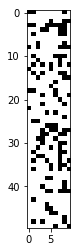

In [84]:
visualize(vis_Z[:50])